In [3]:
%load_ext tensorboard

In [4]:
import numpy as np
import tensorflow as tf
import re
import pandas as pd
import spacy
import gc
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack as sparse_vstack
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense,Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.callbacks import TensorBoard

# **FASE 1**

In [5]:
# Step 1: Load data
train_df = pd.read_csv('train.csv', encoding='latin1')
test_df = pd.read_csv('test.csv', encoding='latin1')

def limpiar_texto(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto)).lower()
    return texto

Por ejemplo, las 3 primeras entradas de `train_df`:

In [6]:
train_df.head(3)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18


Recuento de NaNs:

In [7]:
# Contar NaNs por columna en train_df
print("NaNs en train_df:")
print(train_df.isna().sum())

# Contar NaNs por columna en test_df
print("\nNaNs en test_df:")
print(test_df.isna().sum())

NaNs en train_df:
textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

NaNs en test_df:
textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64


In [8]:
# Eliminar filas con NaN en la columna 'text' en test_df
test_df = test_df.dropna(subset=['text'])

In [9]:
# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)


train_corpus = train_df['text_clean'].tolist()
test_corpus  = test_df ['text_clean'].tolist()
corpus       = train_corpus + test_corpus

print(f"Frases usadas → train: {len(train_corpus)}, test: {len(test_corpus)}")

# 3) Tokenizer limitado a 3000 palabras + OOV
tokenizer = Tokenizer(num_words=3000, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
vocab_size = 3000 + 1

# Diccionarios para después
word2idx = tokenizer.word_index
idx2word = {i:w for w,i in word2idx.items()}

# 4) Top-10 nombres con spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

stop_words = set(nlp.Defaults.stop_words) | {'nan'}


Frases usadas → train: 27481, test: 3534


Distribución de cantidad de palabras por frase:

<Axes: >

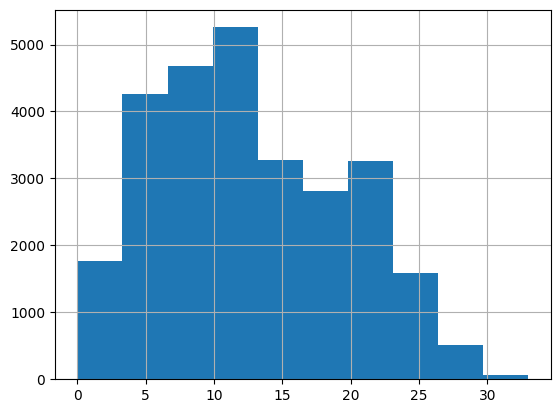

In [10]:
train_df['text_clean'].str.split().map(len).hist()

Número de palabras únicas (vocabulario) que el tokenizer ha aprendido al ajustarse al texto:

In [11]:
len(tokenizer.word_index)

31452

# **FASE 2**

In [12]:
# Lista de palabras a analizar
palabras = [w for w in tokenizer.word_counts if len(w) >= 2 and w not in stop_words]

# Procesamos todas las palabras de una vez (más eficiente)
docs = list(nlp.pipe(palabras, batch_size=1000))

# Filtramos por NOUN o PROPN
filtradas = {
    w: tokenizer.word_counts[w]
    for w, doc in zip(palabras, docs)
    if any(token.pos_ in {"NOUN", "PROPN"} for token in doc)
}

# Top 10
top_10 = sorted(filtradas.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nombres con significado:")
for i, (w, f) in enumerate(top_10, 1):
    print(f"{i}. {w:<15} → {f} apariciones")


Top 10 nombres con significado:
1. day             → 2269 apariciones
2. love            → 1281 apariciones
3. today           → 1218 apariciones
4. lol             → 1062 apariciones
5. time            → 1056 apariciones
6. night           → 834 apariciones
7. home            → 800 apariciones
8. mothers         → 798 apariciones
9. thanks          → 745 apariciones
10. hope            → 660 apariciones


In [13]:
# 5) Secuencias
train_sequences = tokenizer.texts_to_sequences(train_corpus)
test_sequences  = tokenizer.texts_to_sequences(test_corpus)
all_sequences        = train_sequences + test_sequences

In [14]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# Paso 3: Generación de pares con ventanas 2 y 4
pairs_dict = {
    'window_2': [],
    'window_4': []
}

for seq in all_sequences:
    # Ventana 2
    sg_pairs_2, labels_2 = skipgrams(seq, vocab_size, window_size=2, negative_samples=0)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_2'].extend(zip(sg_pairs_2, labels_2))

    # Ventana 4
    sg_pairs_4, labels_4 = skipgrams(seq, vocab_size, window_size=4, negative_samples=0)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_4'].extend(zip(sg_pairs_4, labels_4))


In [15]:
from tensorflow.keras.optimizers import Adam
# Hiperparámetros y estructuras
embedding_sizes  = [45,312,752]
window_sizes     = ['window_2','window_4']
loss_histories   = {}
final_embeddings = {}
models           = {}

for emb_size in embedding_sizes:
    for window in window_sizes:
        current_pairs = pairs_dict[window]
        if not current_pairs:
            continue

        # Separar pares y etiquetas
        pairs, labels = zip(*current_pairs)

        # Separar targets y contexts de los pares
        targets, contexts = zip(*pairs)

        # Convertir a arrays
        targets  = np.array(targets, dtype='int32')
        contexts = np.array(contexts, dtype='int32')
        y_train  = np.array(labels, dtype='float32')

        # ENTRADAS como índices, no one-hot
        target_input = Input(shape=(), dtype='int32', name='target_input')
        context_input= Input(shape=(), dtype='int32', name='context_input')

        # Capa de embeddings compartida
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=emb_size,
            name=f"embedding_{emb_size}_{window}"
        )

        # Vectores de palabras
        target_vector  = embedding_layer(target_input)
        context_vector = embedding_layer(context_input)

        # Producto punto
        dot_product = Dot(axes=-1)([target_vector, context_vector])
        dot_product = Reshape((1,))(dot_product)

        # Clasificador binario
        output = Dense(1, activation='sigmoid')(dot_product)



        # Construir modelo
        model = Model(inputs=[target_input, context_input], outputs=output)
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.02),
            metrics=['accuracy']
        )

        # Guardar y entrenar
        key = f'emb_{emb_size}_{window}'
        print(f"\nEntrenando modelo: {key} (Embedding size: {emb_size}, Window: {window})\n")
        models[key] = model
        history = model.fit(
            [targets, contexts],
            y_train,
            epochs=15,
            batch_size=256,
            verbose=1
        )

        loss_histories[key]   = history.history['loss']
        final_embeddings[key] = embedding_layer.get_weights()[0]


Entrenando modelo: emb_45_window_2 (Embedding size: 45, Window: window_2)

Epoch 1/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9991 - loss: 0.0165
Epoch 2/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 4.3489e-07
Epoch 3/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 1.0000 - loss: 2.7322e-08
Epoch 4/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 2.6399e-09
Epoch 5/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 2.5149e-10
Epoch 6/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 4.3751e-11
Epoch 7/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 1.0000 - loss: 1.8766e-11
Epoch 8/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 1.0000 - loss: 1.1835e-11
Epoch 9/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 8.8302e-12
Epoch 10/15
5417/5417 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 6.8188e-

In [16]:
# Recorre cada modelo en el diccionario y muestra su summary
for key, mdl in models.items():
    print(f"\n=== Summary de {key} ===")
    mdl.summary()



=== Summary de emb_45_window_2 ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ reshape[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_45_window_4 ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1)         │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_312_window_2 ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1)         │          0 │ dot_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ reshape_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_312_window_4 ===


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1)         │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ reshape_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_752_window_2 ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1)         │          0 │ dot_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          2 │ reshape_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)


=== Summary de emb_752_window_4 ===


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1)         │          0 │ dot_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          2 │ reshape_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)

In [17]:
# Example: vector for "love"
idx = word2idx["love"]

print(f"Embedding for 'love':\n{final_embeddings['emb_45_window_2'][idx]}")

Embedding for 'love':
[ 0.74105614  0.6740245   0.75683445  0.52405393 -0.7085156  -0.5024596
  0.6350662  -0.07704248  0.42643216  0.5556382   0.67040443  0.53676456
 -0.63660336  0.6791813   0.7919931  -0.6800809   0.6028327   0.5767973
 -0.61998814  0.6034636   0.6911949  -0.25585598  0.80019766  0.58396566
  0.6175512   0.58356994 -0.67455727 -0.73350453 -0.49969104 -0.7017266
 -0.70927894 -0.12952626 -0.7595802   0.61045396 -0.718638    0.53518
 -0.70629615  0.75800884 -0.63124764  0.610799   -0.5670213   0.6314624
 -0.5926492  -0.5435353   0.56087804]


In [18]:

# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w,_ in top_10]

# 2) Extrae los índices solo de las que realmente estén en tu vocabulario
indices = []
words   = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Recorre cada modelo en final_embeddings
for model_key, emb_matrix in final_embeddings.items():
    # 4) Submatriz de solo las top palabras
    submat = emb_matrix[indices]            # (n_words, emb_dim)

    # 5) Calcula similitud de coseno
    sim_mat = cosine_similarity(submat)     # (n_words, n_words)

    # 6) Construye DataFrame y muestra
    print(f"\n— Similitud de coseno para {model_key} —")
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)
    display(df_sim)




— Similitud de coseno para emb_45_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.954445,0.966589,0.949461,0.965855,0.947300,0.949308,0.960236,0.950896,0.933998
love,0.954445,1.000000,0.967828,0.970620,0.981486,0.971497,0.970600,0.960585,0.963923,0.962258
today,0.966589,0.967828,1.000000,0.960905,0.975335,0.962428,0.949993,0.950353,0.955341,0.951780
lol,0.949461,0.970620,0.960905,1.000000,0.967158,0.961833,0.960531,0.956577,0.947264,0.952588
time,0.965855,0.981486,0.975335,0.967158,1.000000,0.974618,0.969938,0.967343,0.971918,0.959605
night,0.947300,0.971497,0.962428,0.961833,0.974618,1.000000,0.972658,0.945230,0.969623,0.968073
home,0.949308,0.970600,0.949993,0.960531,0.969938,0.972658,1.000000,0.952766,0.976011,0.974274
mothers,0.960236,0.960585,0.950353,0.956577,0.967343,0.945230,0.952766,1.000000,0.943870,0.950775
thanks,0.950896,0.963923,0.955341,0.947264,0.971918,0.969623,0.976011,0.943870,1.000000,0.965425
hope,0.933998,0.962258,0.951780,0.952588,0.959605,0.968073,0.974274,0.950775,0.965425,1.000000



— Similitud de coseno para emb_45_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.943485,0.925667,0.953072,0.951578,0.951515,0.942770,0.953874,0.929264,0.912925
love,0.943485,1.000000,0.957647,0.956842,0.925222,0.950628,0.951309,0.968201,0.926627,0.904173
today,0.925667,0.957647,1.000000,0.928411,0.910179,0.930766,0.919229,0.938216,0.925077,0.882761
lol,0.953072,0.956842,0.928411,1.000000,0.965684,0.964988,0.943860,0.961787,0.937695,0.916875
time,0.951578,0.925222,0.910179,0.965684,1.000000,0.955253,0.941984,0.945416,0.941791,0.914227
night,0.951515,0.950628,0.930766,0.964988,0.955253,1.000000,0.966427,0.958796,0.947233,0.921742
home,0.942770,0.951309,0.919229,0.943860,0.941984,0.966427,1.000000,0.952144,0.947192,0.916913
mothers,0.953874,0.968201,0.938216,0.961787,0.945416,0.958796,0.952144,1.000000,0.940123,0.915041
thanks,0.929264,0.926627,0.925077,0.937695,0.941791,0.947233,0.947192,0.940123,1.000000,0.913920
hope,0.912925,0.904173,0.882761,0.916875,0.914227,0.921742,0.916913,0.915041,0.913920,1.000000



— Similitud de coseno para emb_312_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.855444,0.882502,0.839966,0.853028,0.905014,0.837151,0.755068,0.804806,0.675460
love,0.855444,1.000000,0.897439,0.900971,0.767843,0.885306,0.820481,0.717159,0.798891,0.796082
today,0.882502,0.897439,1.000000,0.841407,0.758526,0.860400,0.801238,0.747957,0.775785,0.703346
lol,0.839966,0.900971,0.841407,1.000000,0.785252,0.853511,0.824654,0.679938,0.726536,0.755647
time,0.853028,0.767843,0.758526,0.785252,1.000000,0.827976,0.782434,0.665502,0.730181,0.637766
night,0.905014,0.885306,0.860400,0.853511,0.827976,1.000000,0.857907,0.714736,0.809209,0.684217
home,0.837151,0.820481,0.801238,0.824654,0.782434,0.857907,1.000000,0.664049,0.736588,0.627789
mothers,0.755068,0.717159,0.747957,0.679938,0.665502,0.714736,0.664049,1.000000,0.626413,0.579422
thanks,0.804806,0.798891,0.775785,0.726536,0.730181,0.809209,0.736588,0.626413,1.000000,0.632950
hope,0.675460,0.796082,0.703346,0.755647,0.637766,0.684217,0.627789,0.579422,0.632950,1.000000



— Similitud de coseno para emb_312_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,-0.097189,-0.132719,0.064096,0.431039,0.475582,0.075047,-0.442295,0.119401,0.196949
love,-0.097189,1.000000,-0.128287,-0.006259,0.001452,-0.053660,-0.248692,-0.006030,0.039220,0.322657
today,-0.132719,-0.128287,1.000000,0.006208,0.079902,0.202481,-0.069175,0.119507,-0.038434,-0.096543
lol,0.064096,-0.006259,0.006208,1.000000,0.094680,-0.027462,-0.004427,-0.164952,-0.185054,0.090419
time,0.431039,0.001452,0.079902,0.094680,1.000000,0.337982,-0.249636,0.054478,0.276520,0.020403
night,0.475582,-0.053660,0.202481,-0.027462,0.337982,1.000000,-0.038768,-0.068414,0.227819,0.160621
home,0.075047,-0.248692,-0.069175,-0.004427,-0.249636,-0.038768,1.000000,-0.124158,-0.037189,-0.087959
mothers,-0.442295,-0.006030,0.119507,-0.164952,0.054478,-0.068414,-0.124158,1.000000,0.135233,-0.088820
thanks,0.119401,0.039220,-0.038434,-0.185054,0.276520,0.227819,-0.037189,0.135233,1.000000,-0.026166
hope,0.196949,0.322657,-0.096543,0.090419,0.020403,0.160621,-0.087959,-0.088820,-0.026166,1.000000



— Similitud de coseno para emb_752_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.780287,0.709853,0.708803,0.712284,0.805978,0.703279,0.773473,0.837886,0.808980
love,0.780287,1.000000,0.725280,0.705502,0.706083,0.780346,0.707644,0.667148,0.818472,0.750754
today,0.709853,0.725280,1.000000,0.653328,0.614400,0.720925,0.626048,0.630178,0.733179,0.744610
lol,0.708803,0.705502,0.653328,1.000000,0.634560,0.706982,0.610299,0.636692,0.727035,0.673829
time,0.712284,0.706083,0.614400,0.634560,1.000000,0.707056,0.656049,0.591890,0.714407,0.733810
night,0.805978,0.780346,0.720925,0.706982,0.707056,1.000000,0.702335,0.728787,0.813051,0.789761
home,0.703279,0.707644,0.626048,0.610299,0.656049,0.702335,1.000000,0.597579,0.737710,0.680061
mothers,0.773473,0.667148,0.630178,0.636692,0.591890,0.728787,0.597579,1.000000,0.737826,0.714906
thanks,0.837886,0.818472,0.733179,0.727035,0.714407,0.813051,0.737710,0.737826,1.000000,0.781754
hope,0.808980,0.750754,0.744610,0.673829,0.733810,0.789761,0.680061,0.714906,0.781754,1.000000



— Similitud de coseno para emb_752_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.493937,0.497912,0.499525,0.471343,0.477072,0.481092,0.501788,0.431624,0.547027
love,0.493937,1.000001,0.486885,0.552860,0.556480,0.521164,0.538391,0.372777,0.412996,0.476990
today,0.497912,0.486885,1.000000,0.472136,0.472849,0.458898,0.503656,0.342982,0.537971,0.585586
lol,0.499525,0.552860,0.472136,1.000000,0.441562,0.495427,0.519056,0.355284,0.372491,0.457961
time,0.471343,0.556480,0.472849,0.441562,1.000000,0.497235,0.512145,0.383698,0.413175,0.500076
night,0.477072,0.521164,0.458898,0.495427,0.497235,1.000000,0.461234,0.309646,0.376921,0.477968
home,0.481092,0.538391,0.503656,0.519056,0.512145,0.461234,1.000000,0.337559,0.393909,0.534579
mothers,0.501788,0.372777,0.342982,0.355284,0.383698,0.309646,0.337559,1.000000,0.299396,0.360996
thanks,0.431624,0.412996,0.537971,0.372491,0.413175,0.376921,0.393909,0.299396,1.000000,0.422938
hope,0.547027,0.476990,0.585586,0.457961,0.500076,0.477968,0.534579,0.360996,0.422938,1.000000


In [19]:


# Define aquí tres grupos basados en tu top-10
grupos = {
    'Día/Mañana':     ['day', 'today', 'morning'],
    'Emoción Positiva':['love', 'hope', 'thanks'],
    'Risa/Conversación':['lol', 'thanks', 'mothers']  # ejemplo mixto
}

for model_key, emb_matrix in final_embeddings.items():
    print(f"\n=== Similitudes para {model_key} ===")
    # Extrae solo los vectores de tus 10 palabras
    submat = emb_matrix[indices]           # (10, emb_dim)
    sim_mat = cosine_similarity(submat)    # (10, 10)

    # Mapea palabra -> posición en 'words'
    pos = {w:i for i,w in enumerate(words)}

    for nombre, group in grupos.items():
        # Filtra solo los que realmente están en tu top
        valid = [w for w in group if w in pos]
        idxs  = [pos[w] for w in valid]
        if len(idxs) < 2:
            print(f"  * Grupo «{nombre}» tiene <2 palabras válidas, omito.")
            continue

        sims = []
        print(f"\n  Grupo «{nombre}»: {valid}")
        for i,j in combinations(idxs, 2):
            s = sim_mat[i, j]
            sims.append(s)
            print(f"    Sim({words[i]}, {words[j]}) = {s:.3f}")

        print(f"    → Similitud media = {np.mean(sims):.3f}")




=== Similitudes para emb_45_window_2 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = 0.967
    → Similitud media = 0.967

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.962
    Sim(love, thanks) = 0.964
    Sim(hope, thanks) = 0.965
    → Similitud media = 0.964

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = 0.947
    Sim(lol, mothers) = 0.957
    Sim(thanks, mothers) = 0.944
    → Similitud media = 0.949

=== Similitudes para emb_45_window_4 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = 0.926
    → Similitud media = 0.926

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.904
    Sim(love, thanks) = 0.927
    Sim(hope, thanks) = 0.914
    → Similitud media = 0.915

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = 0.938
    Sim(lol, mothers) = 0.962
    Sim(thanks, mothers) = 0.940
    → Similitud media = 0.947

=== Simil

# **FASE 3**

In [20]:
# --- FASE 3: DOS RNN SECUENCIALES CON EMBEDDINGS PRE-ENTRENADOS ---

# Parámetros generales
maxlen        = 32
batch_rnn     = 64
epochs_rnn    = 15
learning_rate = 0.01

# 1) Usa SMALL_TRAIN_DF / SMALL_TEST_DF y quita filas sin etiqueta
train_df.dropna(subset=['sentiment'], inplace=True)
test_df.dropna(subset=['sentiment'], inplace=True)

texts_train = train_df['text_clean'].tolist()
texts_test  = test_df['text_clean'].tolist()

# 2) LabelEncoder para convertir strings → enteros
le       = LabelEncoder()
y_train  = le.fit_transform(train_df['sentiment'])
y_test   = le.transform(test_df['sentiment'])
y_train  = y_train.astype('int32')
y_test   = y_test.astype('int32')
num_classes = len(le.classes_)
print("Clases sentiment codificadas:", le.classes_)

# 3) Secuencias + padding
seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)
X_train   = pad_sequences(seq_train, maxlen=maxlen, padding='post')
X_test    = pad_sequences(seq_test,  maxlen=maxlen, padding='post')

# 4) Crea datasets optimizados
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                         .shuffle(len(X_train)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)

# 5) Elige qué embeddings usar
key_A = 'emb_45_window_2'
key_B = 'emb_312_window_2'
emb_A = final_embeddings[key_A]
emb_B = final_embeddings[key_B]
vocab_sz = vocab_size



Clases sentiment codificadas: ['negative' 'neutral' 'positive']


In [21]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

# --- Modelo A con regularización y dropout ---
model_A = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_A.shape[1],
              weights=[emb_A],
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    Dropout(0.4),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_A')

model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_A.summary()
# --- Modelo B con regularización y dropout ---
model_B = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_B.shape[1],
              weights=[emb_B],
              trainable=True),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_B')

model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_B.summary()

Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       135,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,045 (527.52 KB)

 Trainable params: 135,045 (527.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       936,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936,312 (3.57 MB)

 Trainable params: 936,312 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # monitor validation loss
    factor=0.5,             # reduce by half
    patience=1,             # after 1 epoch with no improvement
    min_lr=1e-5,            # don't go below this
    verbose=1
)

In [25]:
## nota: PARA EJECUTAR DE NUEVO, ANTES EJECUTAR LA DEFINICIÓN DE LOS MODELOS PARA QUE EMPIECEN DE CERO
# 8) Entrena ambos
print("\n>>> Entrenando Model A")
history_A = model_A.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

print("\n>>> Entrenando Model B")
history_B = model_B.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_rnn,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)




>>> Entrenando Model A
Epoch 1/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.3242 - loss: 1.1220 - val_accuracy: 0.2832 - val_loss: 1.1029 - learning_rate: 0.0100
Epoch 2/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4569 - loss: 0.9961 - val_accuracy: 0.6587 - val_loss: 0.8153 - learning_rate: 0.0100
Epoch 3/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6880 - loss: 0.7591 - val_accuracy: 0.7023 - val_loss: 0.7089 - learning_rate: 0.0100
Epoch 4/15
427/430 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7055 - loss: 0.7161
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7055 - loss: 0.7162 - val_accuracy: 0.7128 - val_loss: 0.7213 - learning_rate: 0.0100
Epoch 5/15
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7237 - loss: 0.6903 - val_accuracy: 0.7162 - val_loss: 0.6881 - learning_rate: 0.0050
Epoch 6/15
429/430 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - ac

## MODELO A

In [26]:
import numpy as np

# Get predicted class probabilities
y_probs = model_A.predict(X_test)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


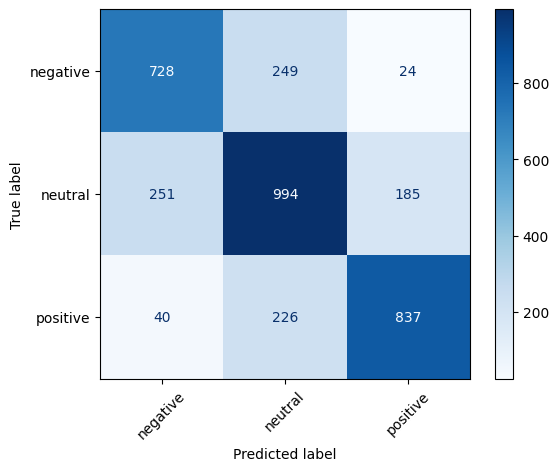

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


## MODELO B

In [28]:
import numpy as np

# Get predicted class probabilities
y_probs = model_B.predict(X_test)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


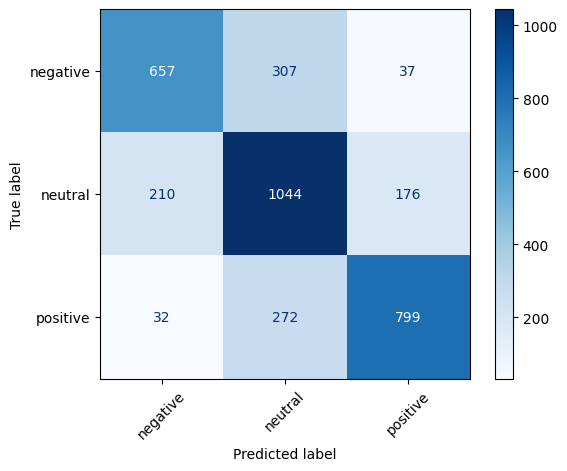

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


=== Evaluación en TEST ===

--- Model A ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.73      0.72      1001
     neutral       0.68      0.70      0.69      1430
    positive       0.80      0.76      0.78      1103

    accuracy                           0.72      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.73      0.72      0.72      3534


--- Model B ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.66      0.69      1001
     neutral       0.64      0.73      0.68      1430
    positive       0.79      0.72      0.76      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.70      0.71      3534
weighted avg       0.71      0.71      0.71      3534



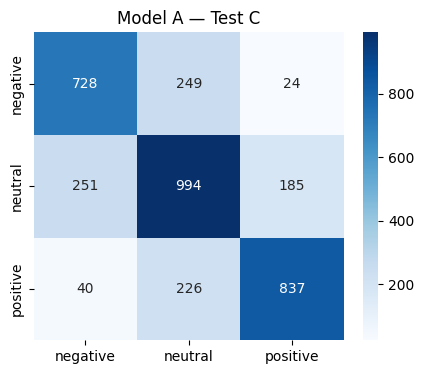

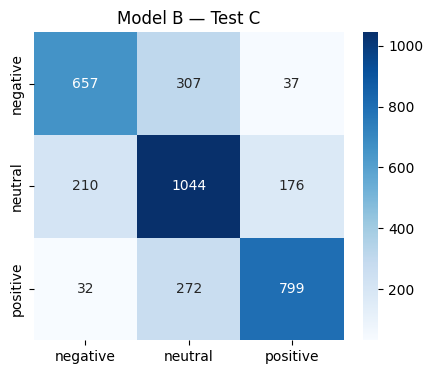

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n=== Evaluación en TEST ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    print(f"\n--- {name} ---")

    # Predicción en test
    y_test_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_probs, axis=1)

    # Matriz de confusión
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Métricas detalladas
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Gráfico
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} — Test C')


In [ ]:
# List of sample indices to test
sample_indices = [0,1,2]

# Loop through each sample
for idx in sample_indices:
    # 1) Saca una frase de prueba
    sample_text = test_df['text_clean'].iloc[idx]
    print(f"\n-----\nSample text: {sample_text}")

    # 2) Tokeniza y paddea la frase
    sample_seq = tokenizer.texts_to_sequences([sample_text])
    sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')

    # 3) MODELO A
    print("=================Utilizando el modelo A=================")
    model = model_A  # o model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")

    # MODELO B
    print("=================Utilizando el modelo B=================")
    model = model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")
